In [1]:
#Installing Nececcary Libraries With Messages Supressed
suppressPackageStartupMessages({
    library(tidyverse)
    library(repr)
    library(tidymodels)
})

options(repr.matrix.max.rows = 10)

#Set seed to make random results reproducible 
set.seed(13) 

#changing the default graph size:
options(repr.plot.width=10, repr.plot.height=8)

Heart disease, also known as cardiovascular disease, involves a range of conditions that affect the heart and blood vessels. It is a leading global health concern, responsible for a significant portion of mortality and morbidity. Various factors contribute to its development, including lifestyle choices, genetics, and environmental factors. Atherosclerosis, the buildup of plaque in arteries, commonly precedes the disease. Hypertension, high cholesterol, smoking, and obesity are key risk factors. Heart diseases manifest in diverse ways, such as angina, heart attacks, heart failure, and arrhythmias.



In [2]:
#Importing Heart Disease data from the UC Irvine Repository

url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
temp <- tempfile()
download.file(url, temp)
data.hungary <- read.csv(unz(temp, "processed.hungarian.data"))
unlink(temp)

The aim of this project is to look at the predictive risk factors for heart disease and how significantly these factors contribute to the development of disease. Some of the specific variables that will be analyzed include: resting heart rate, blood pressure and chest pain scores.

In [3]:
formatted_heart_disease<-data.hungary |> 
    #renaming columns 
    rename(age = X28, sex = X1, chest_pain_type = X2, resting_bp = X130, 
        cholesterol = X132, fasting_blood_sugar = X0, resting_ekg = X2.1, max_hr = X185, exercise_induced_angina = X0.1, 
        ST_drop_exercise = X0.2, ST_slope = X., fluoroscopy_count = X..1, thalassemia_type = X..2, vessel_narrow = X0.3
    )|>
    #transofrming variables from <char> to <int> or <fct>
    transform(resting_bp = as.integer(resting_bp), cholesterol = as.integer(cholesterol), 
        fasting_blood_sugar = as.integer(fasting_blood_sugar), resting_ekg = as.integer(resting_ekg), max_hr = as.integer(max_hr), 
        exercise_induced_angina = as.integer(exercise_induced_angina), ST_slope = as.integer(ST_slope),
        fluoroscopy_count = as.integer(fluoroscopy_count),thalassemia_type = as.integer(thalassemia_type), 
        vessel_narrow = as.factor(vessel_narrow), sex=as.integer(sex),chest_pain_type=as.integer(chest_pain_type))


Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”
Warning message in eval(substitute(list(...)), `_data`, parent.frame()):
“NAs introduced by coercion”


In [4]:
#Before proceeding further into analyzing the data, we need to split it into a training and testing set. The testing set will not be analyzed and will be set aside for testing later.
# %75 of data will be used for testing and the remaining %25 for training
heart_disease_split<-initial_split(formatted_heart_disease, prop=0.75, strata=vessel_narrow)
heart_disease_train<-training(heart_disease_split)
heart_disease_test<-testing(heart_disease_split)

In [5]:
#According to the db: 
    #sex (1 = male; 0 = female)

    #chest pain type:
            # -- Value 1: typical angina
            # -- Value 2: atypical angina
            # -- Value 3: non-anginal pain
            # -- Value 4: asymptomatic

    #exercise induced angina (1 = yes; 0 = no)

    #esting electrocardiographic results
            # -- Value 0: normal
            # -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
            # -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

    #(fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

    #slope: the slope of the peak exercise ST segment
    #         -- Value 1: upsloping
    #         -- Value 2: flat
    #         -- Value 3: downsloping

    #thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

    #num: diagnosis of heart disease (angiographic disease status)
            # -- Value 0: < 50% diameter narrowing
            # -- Value 1: > 50% diameter narrowing
            # (in any major vessel: attributes 59 through 68 are vessels)

#Refactoring the above categorical variables to make the data more readable and easier to work with:
refactored_heart_disease<-heart_disease_train|>
    transform(resting_bp = as.integer(resting_bp), cholesterol = as.integer(cholesterol), 
        fasting_blood_sugar = as.factor(fasting_blood_sugar), resting_ekg = as.factor(resting_ekg), max_hr = as.integer(max_hr), 
        exercise_induced_angina = as.factor(exercise_induced_angina), ST_slope = as.factor(ST_slope),
        fluoroscopy_count = as.integer(fluoroscopy_count),thalassemia_type = as.factor(thalassemia_type), 
        vessel_narrow = as.factor(vessel_narrow), sex=as.factor(sex),chest_pain_type=as.factor(chest_pain_type
    ))|>
    mutate(sex=fct_recode(sex, "male"="1", "female"="0"
    ))|>
    mutate(chest_pain_type=fct_recode(chest_pain_type,
        "typical_angina"="1",
        "atypical_angina"="2",
        "non_anginal_pain"="3",
        "asymptomatic"="4"
    ))|>
    mutate(exercise_induced_angina=fct_recode(exercise_induced_angina,
        "yes"="1",
        "no"="0"
    ))|>
    mutate(resting_ekg=fct_recode(resting_ekg,
        "normal"="0",
        "ST-T_wave_abnormality"="1",
        "left_ventricular_hypertrophy"="2"
    ))|>
    mutate(fasting_blood_sugar=fct_recode(fasting_blood_sugar,
        "above120mg/dl"="1",
        "below120mg/dl"="0"
    ))|>
    mutate(ST_slope=fct_recode(ST_slope,
        "upsloping"="1",
        "flat"="2",
        "downsloping"="3"
    ))|>
    mutate(thalassemia_type=fct_recode(thalassemia_type,
        "normal"="3",
        "fixed_defect"="6",
        "reversable_defect"="7")
    )|>
    mutate(vessel_narrow=fct_recode(vessel_narrow,
        "below_50%of_d"="0",
        "above_50%of_d"="1"))
    
        
formatted_heart_disease


age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ekg,max_hr,exercise_induced_angina,ST_drop_exercise,ST_slope,fluoroscopy_count,thalassemia_type,vessel_narrow
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
29,1,2,120,243,0,0,160,0,0,NA,NA,NA,0
29,1,2,140,NA,0,0,170,0,0,NA,NA,NA,0
30,0,1,170,237,0,1,170,0,0,NA,NA,6,0
31,0,2,100,219,0,1,150,0,0,NA,NA,NA,0
32,0,2,105,198,0,0,165,0,0,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
52,1,4,160,331,0,0,94,1,2.5,NA,NA,NA,1
54,0,3,130,294,0,1,100,1,0.0,2,NA,NA,1
56,1,4,155,342,1,0,150,1,3.0,2,NA,NA,1


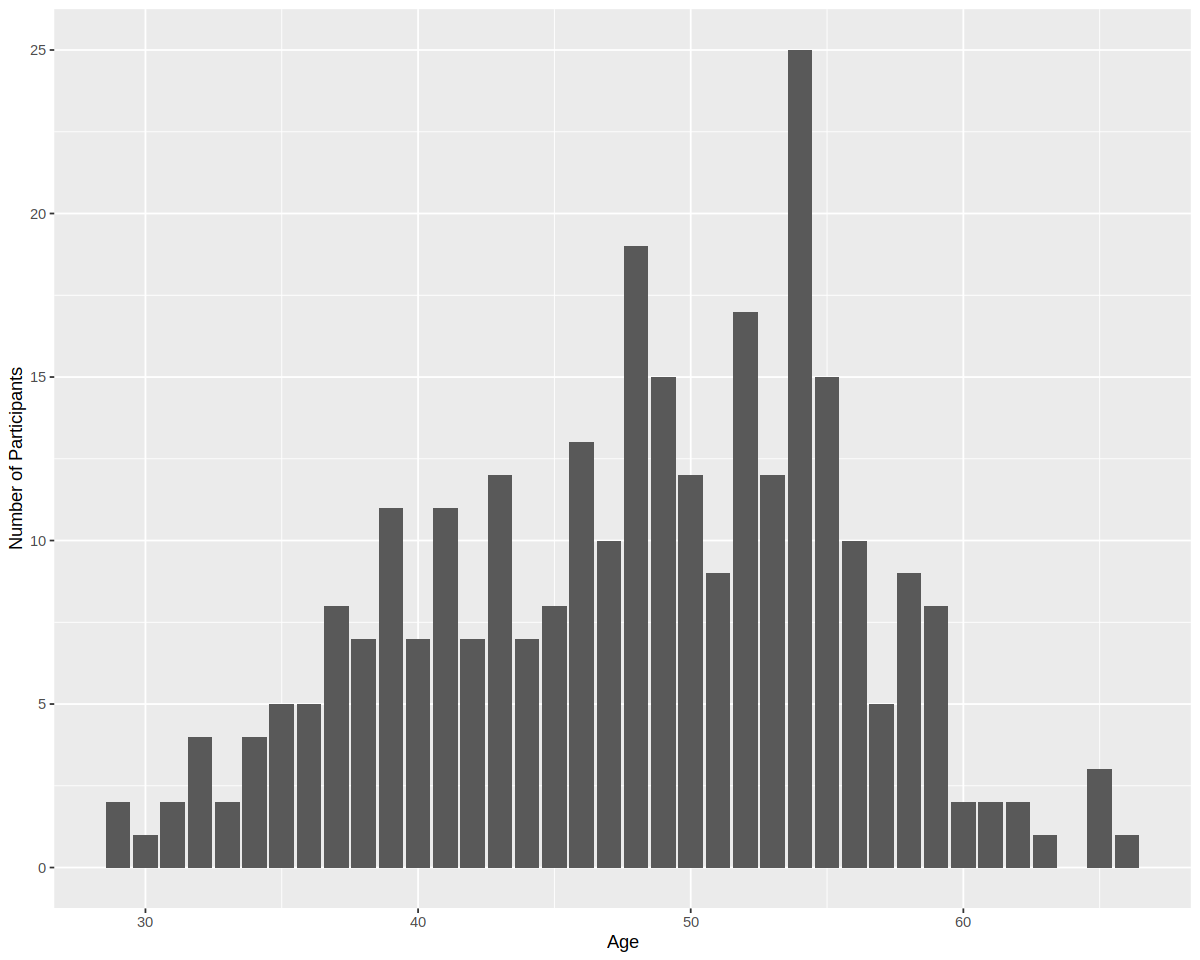

In [28]:
#Here will will show how many data points we have for each age to get an idea of what population we are studying, and display it as a bar graph
Summary_table <- formatted_heart_disease |>
                count(age)

Summary_graph <-  ggplot(Summary_table, aes(x = age, y = n)) +
                    geom_bar(stat = "identity") +
                    labs(x = "Age", y = "Number of Participants")

Summary_graph

In [10]:
#Before proceeding further into analyzing the data, we need to split it into a training and testing set. The testing set will not be analyzed and will be set aside for testing later.
# %75 of data will be used for testing and the remaining %25 for training
heart_disease_split<-initial_split(formatted_heart_disease, prop=0.75, strata=vessel_narrow)
heart_disease_train<-training(heart_disease_split)
heart_disease_test<-testing(heart_disease_split)


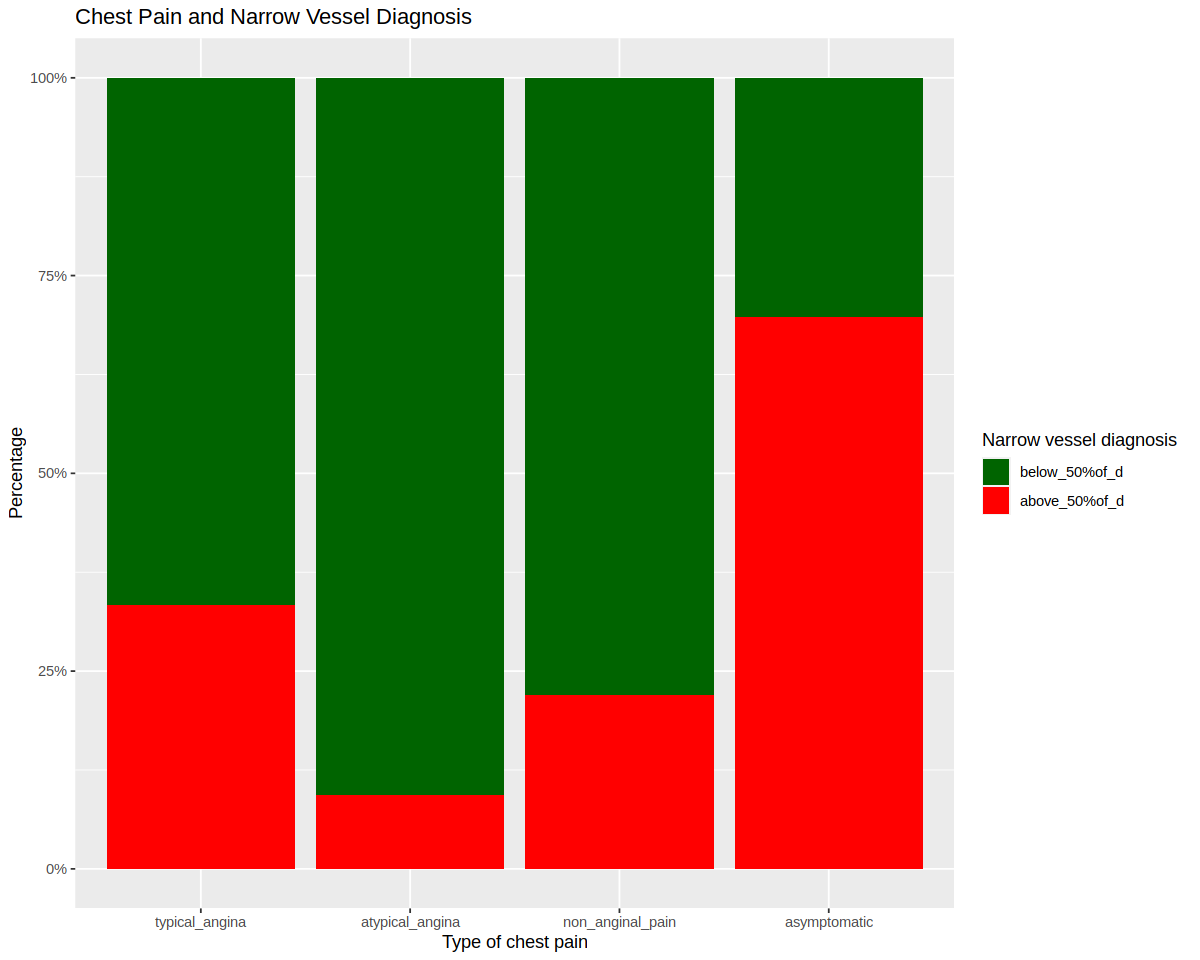

In [11]:
#Exploring The Relationship Between Chest Pain Type and narrow vessel diagnostic:
pain_vessel_graph<-refactored_heart_disease|>
    ggplot(aes(x=chest_pain_type, fill=vessel_narrow))+
        geom_bar(position="fill")+
        scale_y_continuous(labels = percent_format(scale = 100)) +
        ylab("Percentage")+
        labs( title = "Chest Pain and Narrow Vessel Diagnosis", x="Type of chest pain", fill="Narrow vessel diagnosis")+
        scale_fill_manual(values=c("darkgreen","red"))
        

pain_vessel_graph

From the bar plot above, we can see that most heart disease diagnoses are associated with typical angina pain or asymptomatic pain. It is also clear that chest pain type can be useful for predicting the heart disease diagnosis. 

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


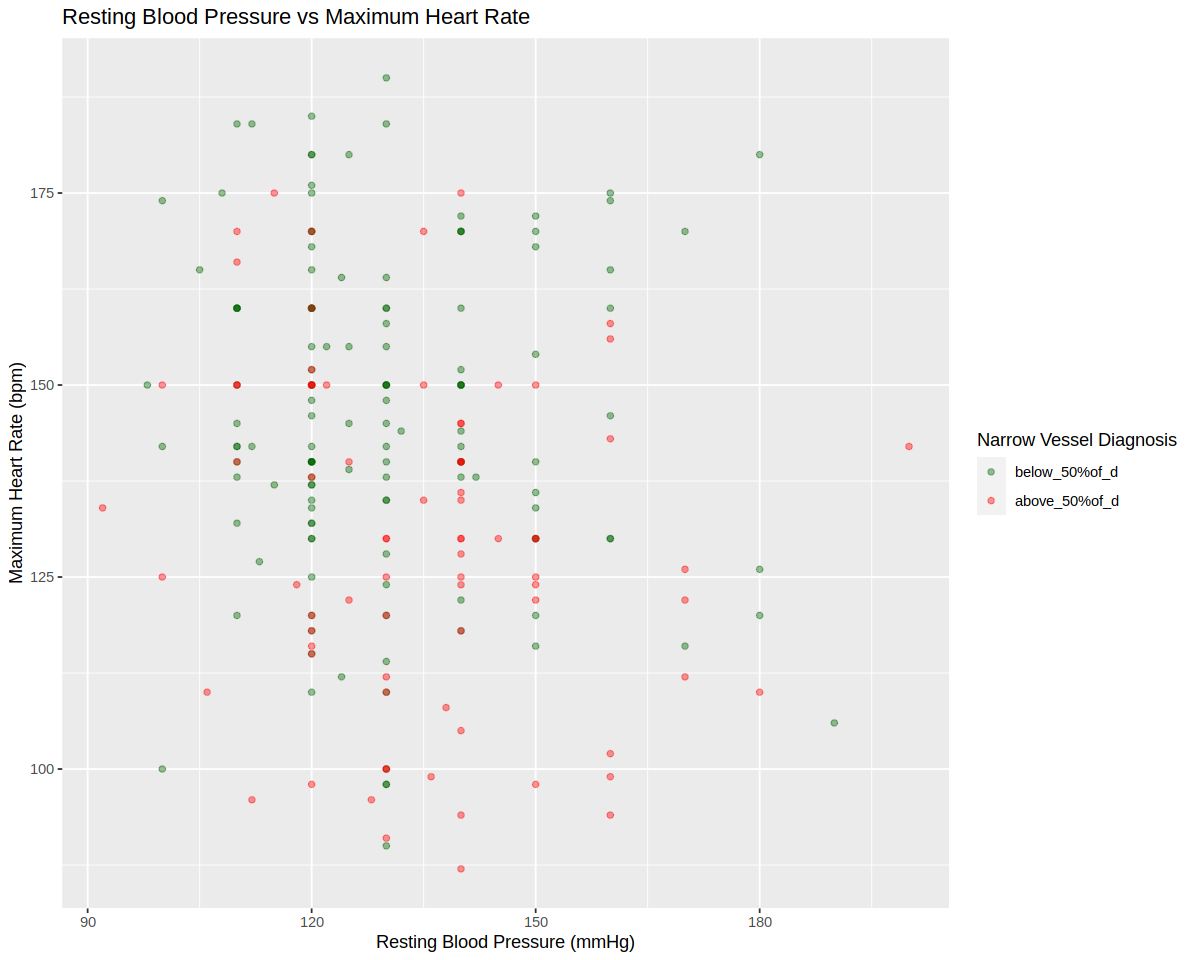

In [12]:
#Exploring the relationship between resting blood pressure, maximum heart rate and the narrow vesel diagnosis:
restingbp_maxhr_graph<-refactored_heart_disease|>
    ggplot(aes(x=resting_bp, y=max_hr, color=vessel_narrow))+
        geom_point(alpha=0.4)+
        labs(title="Resting Blood Pressure vs Maximum Heart Rate", x="Resting Blood Pressure (mmHg)", y="Maximum Heart Rate (bpm)", color="Narrow Vessel Diagnosis")+
        scale_color_manual(values=c("darkgreen","red"))

restingbp_maxhr_graph

In [13]:
#Using forward selection, determine what set of predictors will result in the highest accuracy 
#KNN classificaiton 
#removing predictors with too many missing values 
heart_disease_train<-select(heart_disease_train, -ST_slope, -fluoroscopy_count,-thalassemia_type)
#removing rows with missing values
heart_disease_train <- na.omit(heart_disease_train)
#installing the kknn package
install.packages("kknn")

#extracting all the potential predictors from the data frame except for the categorical label variable vessel_narrow
names<-colnames(heart_disease_train |>select(-vessel_narrow))



#make an empty tibble for storing accuracies (used later)
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

#make your standard knn specification - every neighbour gets same vote power, classification problem, kknn engine 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(heart_disease_train, v = 2, strata = vessel_narrow)


number_of_predictors <- length(names)

# store the selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (index in 1:number_of_predictors) {
    # for every predictor:
    accuracy <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("vessel_narrow", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                            data = heart_disease_train) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accuracy[[j]] <- acc
        models[[j]] <- model_string
    }
    jbest <- which.max(unlist(accuracy))
    accuracies <- accuracies |> 
      add_row(size = index, 
              model_string = models[[jbest]], 
              accuracy = accuracy[[jbest]])
    selected <- c(selected, names[[jbest]])
    names <- names[-jbest]
}
accuracies



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



size,model_string,accuracy
<int>,<chr>,<dbl>
1,vessel_narrow ~ ST_drop_exercise,0.7816430
2,vessel_narrow ~ ST_drop_exercise+chest_pain_type,0.8173057
3,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp,0.8376108
4,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg,0.8579159
5,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg+sex,0.8781694
6,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg+sex+age,0.8730674
7,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg+sex+age+cholesterol,0.8730674
8,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg+sex+age+cholesterol+fasting_blood_sugar,0.8477118
9,vessel_narrow ~ ST_drop_exercise+chest_pain_type+resting_bp+resting_ekg+sex+age+cholesterol+fasting_blood_sugar+exercise_induced_angina,0.8479180


In [11]:
most_accurate_predictors<-slice_max(accuracies, accuracy, n=1)
most_accurate_predictors

size,model_string,accuracy
<int>,<chr>,<dbl>
4,vessel_narrow ~ exercise_induced_angina+ST_drop_exercise+cholesterol+max_hr,0.851357


    Studying risk factors for heart disease in middle to high-income countries, one would expect insights into various health factors that contribute to cardiovascular health in these populations. This analysis could uncover patterns related to lifestyle choices, such as smoking habits, the prevalence of atherosclerosis, rates of hypertension, and elevated cholesterol levels.

    Understanding these factors can aid in tailoring targeted health interventions and policies to reduce the prevalence of heart disease. Additionally, the insights gained from the results and methodology of this study can contribute to developing accurate computer models for predicting heart disease. These models can enhance early risk assessment, personalized healthcare, and more effective disease management, ultimately leading to improved public health outcomes and reduced healthcare costs.


    This research will lay the framework for future inquiries at the intersection of healthcare and data science. Moving forward this could include exploring optimization of interventions, long-term effects of risk factor modifications, and ethical considerations in predictive modelling, ultimately enhancing public health and data analytics.